In [107]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy import stats
import umap

import anndata as ad
import scanpy as sc
import squidpy as sq
import seaborn as sns
import h5py
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

# mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# # Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [108]:
#Define the path where the files are located
DATA_PATH=('/mnt/ibm_lg/leah.dorman/Nanostring/Data/IBD_Michael_Kattah/')
data_files = os.listdir(os.path.join(DATA_PATH,'raw_data'))
data_files

#note: I reversed the .jpg images by flipping vertically so they match with the nanostring coordinates in squidpy. 

['CellLabels',
 'CellTypeSummary_R5276_S3_IBD.csv',
 'R5276_S3_IBD_tx_file.csv',
 'R5276_S3_IBD_fov_positions_file.csv',
 '.ipynb_checkpoints',
 'R5276_S3_IBD_exprMat_file.csv',
 'R5276_S3_IBD_metadata_file.csv',
 'CellOverlay',
 'CompartmentLabels',
 'CellComposite']

In [109]:

cts = [s for s in data_files if 'exprMat' in s][0]
fov = [s for s in data_files if 'fov' in s][0]
meta= [s for s in data_files if 'metadata_file' in s][0]
annotations_file = [s for s in data_files if 'CellTypeSummary' in s][0]

print(cts,fov,meta)

R5276_S3_IBD_exprMat_file.csv R5276_S3_IBD_fov_positions_file.csv R5276_S3_IBD_metadata_file.csv


In [110]:
ndata = sq.read.nanostring(os.path.join(DATA_PATH,'raw_data'),counts_file = cts,meta_file = meta,fov_file = fov)

In [111]:
annotations = pd.read_csv(os.path.join(DATA_PATH,'raw_data',meta),index_col=0)
annotations


,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
fov,,,,,,,,,,,,,,,,,,,
1,1,1094,1.79,2288,3635,13499.111111,-113676.111111,50,28,542,3013,2527,12910,115,626,116,1211,2967,10729
1,2,987,0.83,2329,3629,13540.111111,-113682.111111,33,40,721,3455,1776,9342,123,603,155,3952,1896,5974
1,3,1420,1.05,2364,3627,13575.111111,-113684.111111,46,44,750,3560,1251,10052,110,6127,115,4912,504,2429
1,4,3293,0.61,2445,3599,13656.111111,-113712.111111,61,100,3035,20988,181,1662,445,8168,96,581,953,4740
1,5,3160,0.75,2541,3606,13752.111111,-113705.111111,64,85,2716,12175,2696,13728,113,628,126,1057,1584,7440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,5161,680,0.97,2375,15,71841.666667,-177557.222222,28,29,889,4648,4576,10965,86,299,163,527,731,2433
21,5162,686,2.04,3013,13,72479.666667,-177559.222222,49,24,28,1200,60,405,64,318,139,442,1237,3926
21,5163,1058,2.83,4047,13,73513.666667,-177559.222222,68,24,1517,11284,247,549,54,1727,70,374,1210,5393


In [112]:
fov

'R5276_S3_IBD_fov_positions_file.csv'

In [113]:
ndata

AnnData object with n_obs × n_vars = 66379 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov'

In [114]:
# Use the global (x,y) coordinates for spatial info, for visualization of all fovs.
ndata.obsm["X_spatial"] = ndata.obsm["spatial_fov"]
ndata.write_h5ad(os.path.join(DATA_PATH,'processed_data/nanostring_IBD.h5ad'))

In [115]:
# spatial coordinates
global_x = ndata.obs["CenterX_global_px"]
global_y = ndata.obs["CenterY_global_px"]
global_y

1_1       -113676.111111
2_1       -113682.111111
3_1       -113684.111111
4_1       -113712.111111
5_1       -113705.111111
               ...      
5161_21   -177557.222222
5162_21   -177559.222222
5163_21   -177559.222222
5164_21   -177560.222222
5165_21   -177561.222222
Name: CenterY_global_px, Length: 66379, dtype: float64

In [116]:
ndata.obsm["spatial_fov"]

array([[  13499.11111111, -113676.11111111],
       [  13540.11111111, -113682.11111111],
       [  13575.11111111, -113684.11111111],
       ...,
       [  73513.66666667, -177559.22222222],
       [  72607.66666667, -177560.22222222],
       [  73684.66666667, -177561.22222222]])

In [117]:
# extract the local and global coordinates and make a list of tuples
#coords_local = [(local_x[i], local_y[i]) for i in range(0, len(local_x))]
coords_global = [(global_x[i], global_y[i]) for i in range(0, len(global_x))]

#coords_local[0:5]

In [118]:
# Add the spatial coordinates to adata.obsm for both local and global
# convert the list of tuples to arrays of tuples (for formatting issue)
#adata_lymph_node_manually_annotated.obsm["X_spatial_local"] = np.asarray(coords_local)
ndata.obsm["X_spatial_global"] = np.asarray(coords_global)

In [119]:
# save the anndata for excellxgene visualization
ndata.write_h5ad(os.path.join(DATA_PATH,'processed_data','nanostring_IBD.h5ad'))

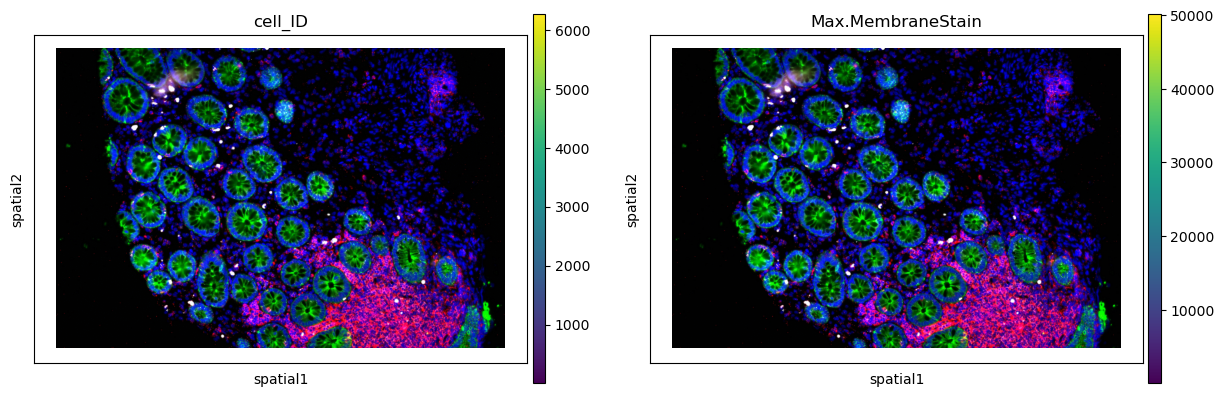

In [120]:
# Check if the raw staining images are also loaded - This needs to be explored further to see what we'd like to visualize)
sc.pl.spatial(ndata, color=["cell_ID","Max.MembraneStain"], 
              library_id="1") # 1st field of view

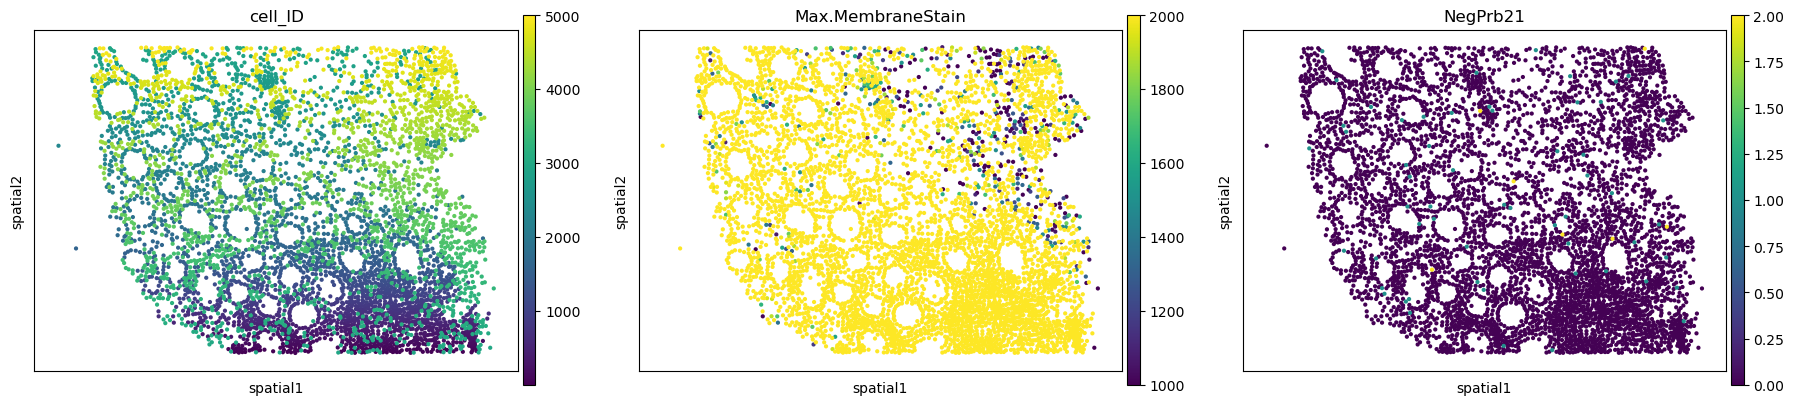

In [121]:
# Check if the raw staining images are also loaded - This needs to be explored further to see what we'd like to visualize)
sc.pl.spatial(ndata[ndata.obs.fov=='1'], color=["cell_ID","Max.MembraneStain","NegPrb21"],
              vmax=[5000,2000,2], vmin=[1, 1000, 0],
              alpha_img=0, library_id="1", spot_size=50) # 1st field of view

In [122]:
ndata.var['mt'] = ndata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ndata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [123]:
ndata.var['ercc'] = ndata.var_names.str.startswith('Neg')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ndata, qc_vars=['ercc'], percent_top=None, log1p=False, inplace=True)

In [124]:
ndata

AnnData object with n_obs × n_vars = 66379 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ercc'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov', 'X_spatial', 'X_spatial_global'

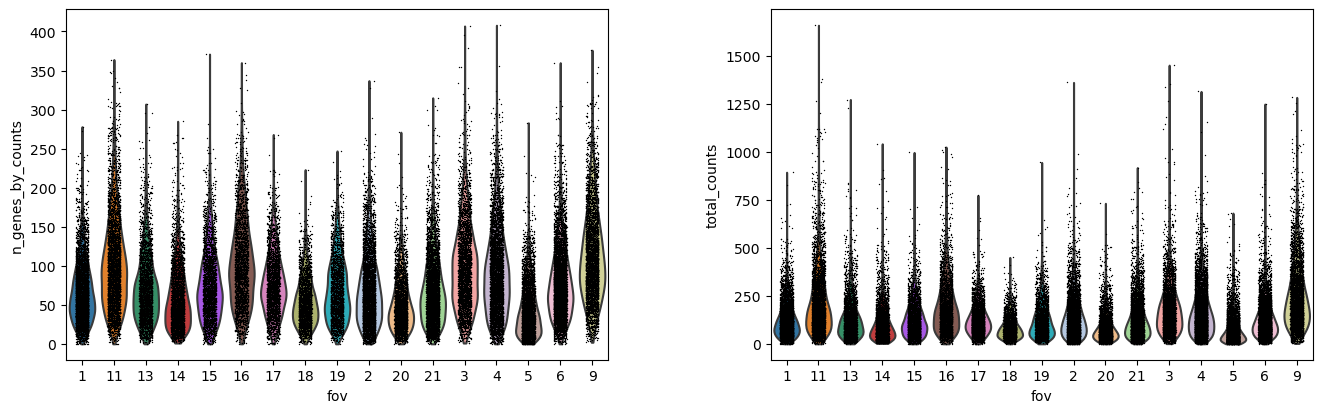

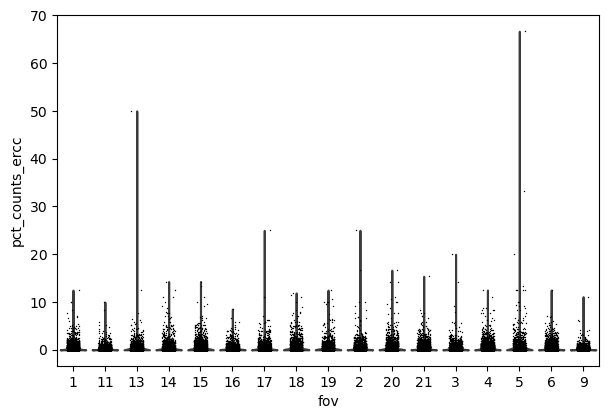

In [125]:
#show distribution of genes detected by field of view
sc.pl.violin(ndata, ['n_genes_by_counts', 'total_counts'], groupby='fov',
             jitter=0.2, multi_panel=True,ncol=2)
sc.pl.violin(ndata, ['pct_counts_ercc'], groupby='fov',
             jitter=0.2, multi_panel=False,ncol=2)

(array([2.0070e+03, 9.1990e+03, 1.2800e+04, 1.2480e+04, 1.0302e+04,
        7.3900e+03, 4.8510e+03, 2.9650e+03, 1.6910e+03, 9.8600e+02,
        5.7800e+02, 3.5200e+02, 2.0800e+02, 1.5200e+02, 1.0500e+02,
        7.0000e+01, 7.8000e+01, 2.9000e+01, 2.4000e+01, 2.5000e+01,
        1.7000e+01, 1.4000e+01, 1.6000e+01, 4.0000e+00, 2.0000e+00,
        3.0000e+00, 6.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  147.  ,   623.62,  1100.24,  1576.86,  2053.48,  2530.1 ,
         3006.72,  3483.34,  3959.96,  4436.58,  4913.2 ,  5389.82,
         5866.44,  6343.06,  6819.68,  7296.3 ,  7772.92,  8249.54,
         8726.16,  9202.78,  9679.4 , 10156.02, 10632.64, 11109.26,
        11585.88, 12062.5 , 12539.12, 13015.74

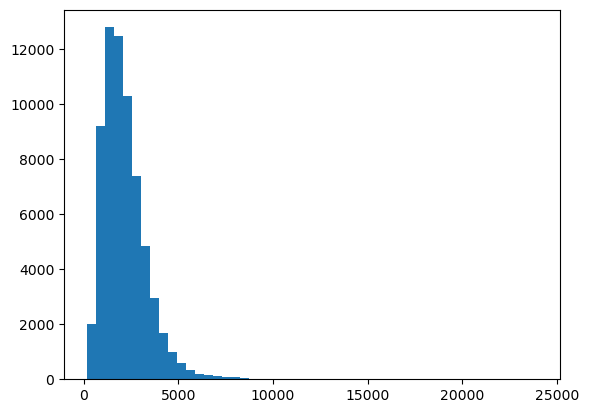

In [126]:
# check the distribution of the cell area
plt.hist(ndata.obs['Area'], bins=50)

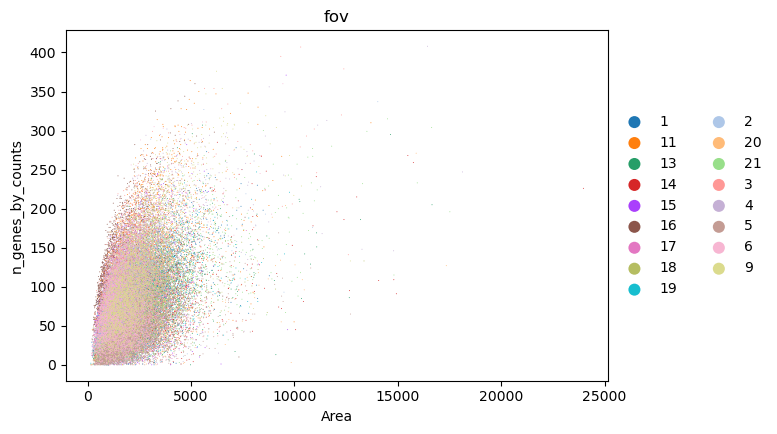

In [127]:
#show correlation between cell size and number of genes detected
sc.pl.scatter(ndata, x='Area', y='n_genes_by_counts',color='fov')

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


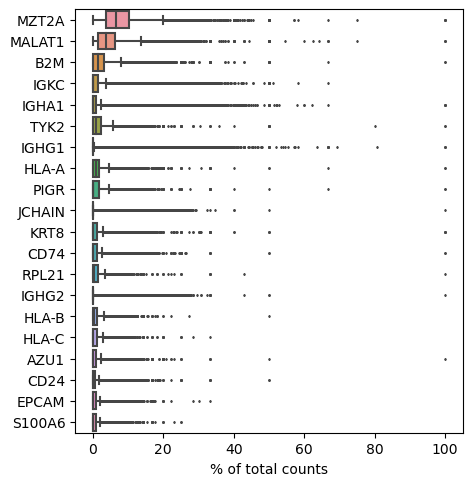

In [128]:
#highest expressed genes
sc.pl.highest_expr_genes(ndata, n_top=20)

#add umap, then save normalized (not scaled) 

#add log normalized counts to adata.raw
#adata.raw = adata (after normalization) because sc defaults to use .raw for DE

#look at how noisy marker gene expression is

#save fov images + h5ad 

In [129]:
ndata.layers['raw_counts']=ndata.X

In [130]:
sc.pp.filter_cells(ndata, min_genes=10)
sc.pp.filter_genes(ndata, min_cells=1)

In [131]:
ndata.var['mt'] = ndata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mtadata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

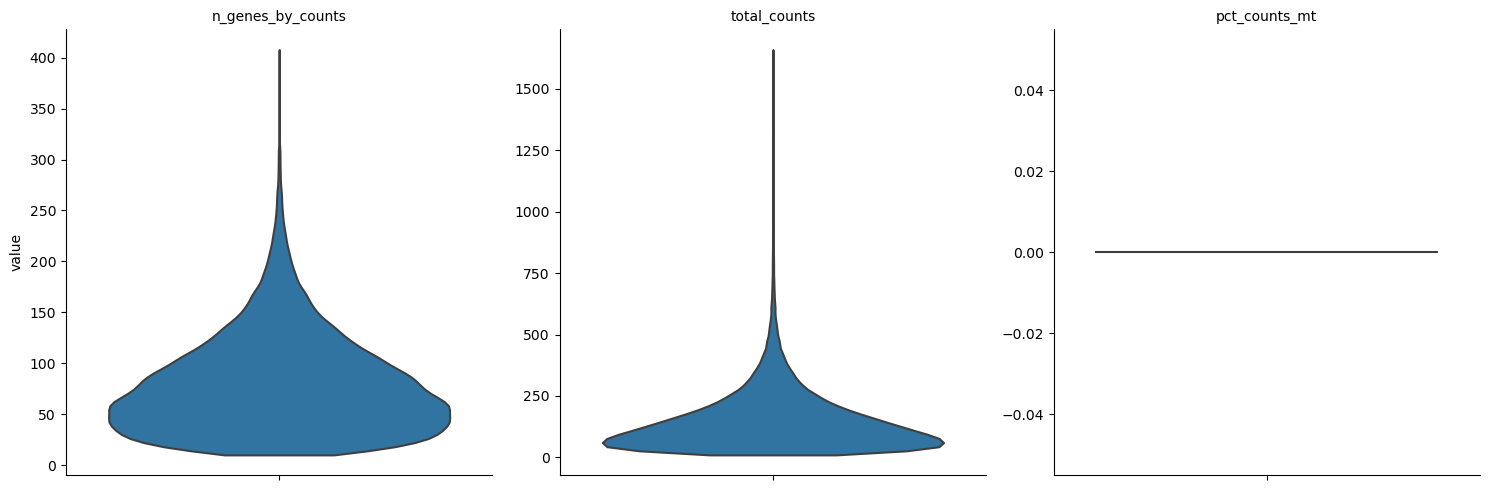

In [132]:
sc.pp.calculate_qc_metrics(ndata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(ndata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, stripplot=False, multi_panel=True)

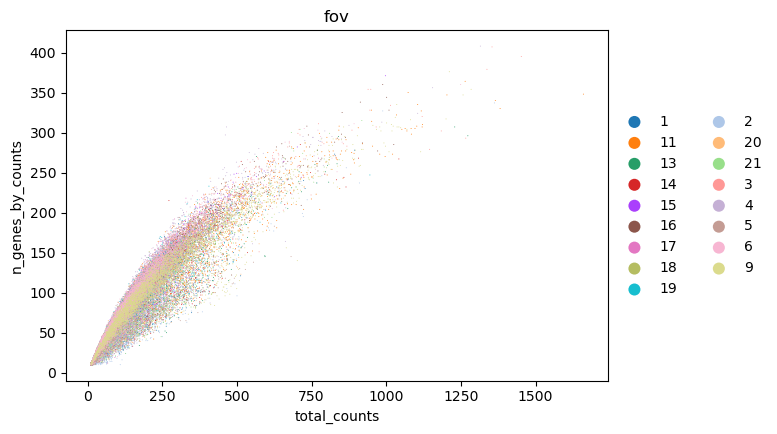

In [133]:

sc.pl.scatter(ndata, x='total_counts', y='n_genes_by_counts',color='fov')

In [134]:
sc.pp.normalize_total(ndata, target_sum=1e4)
sc.pp.log1p(ndata)
ndata.layers['log_normalized_counts']=ndata.X
ndata.raw=ndata

In [135]:
sc.pp.scale(ndata, max_value=10)

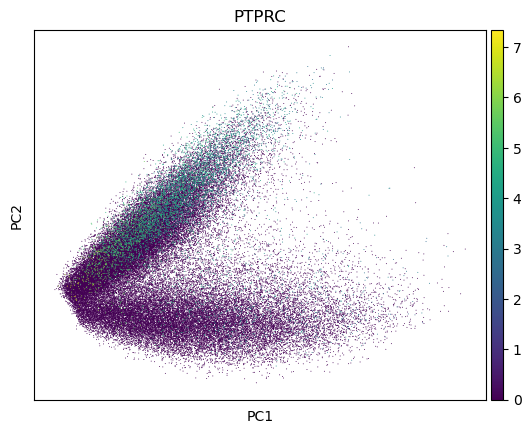

In [136]:
sc.tl.pca(ndata, svd_solver='arpack')
sc.pl.pca(ndata, color='PTPRC')

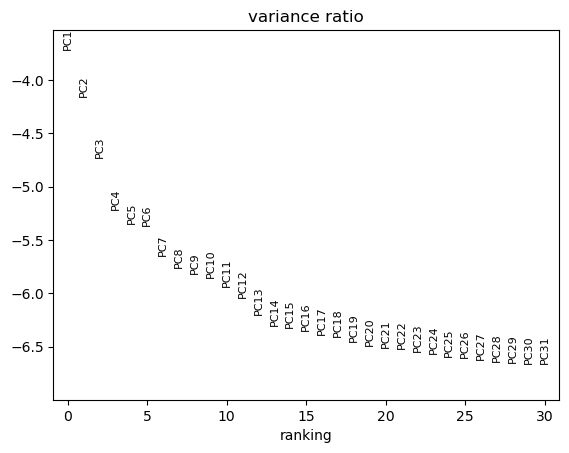

In [137]:
sc.pl.pca_variance_ratio(ndata, log=True)

In [138]:
sc.pp.neighbors(ndata, n_neighbors=10, n_pcs=15)

In [139]:
sc.tl.umap(ndata)

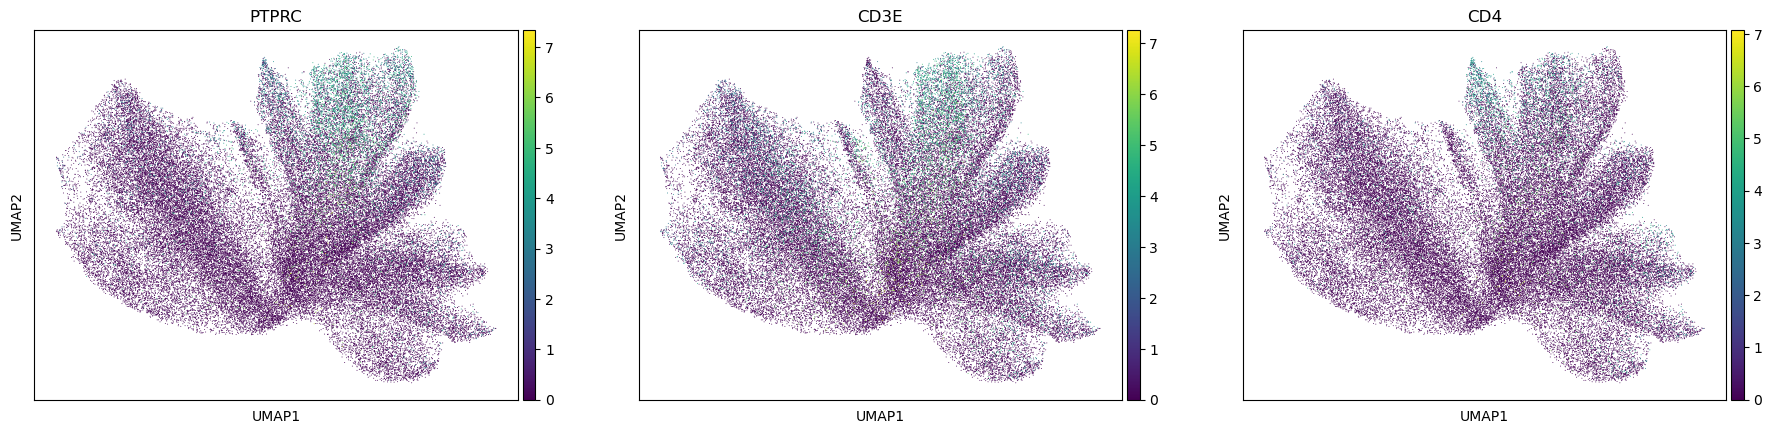

In [140]:
sc.pl.umap(ndata, color=['PTPRC', 'CD3E', 'CD4'])

In [141]:
#ndata.layers['scale_data']=ndata.X
ndata.X=ndata.layers['log_normalized_counts']

Show expression of cell type specific marker genes within the UMAP plot for all fields of view

In [142]:
marker_genes = {
    'CD4_T_Cell':['CD3D', 'CD40LG', 'IL7R'],
    'B_Cell':['CD52','CD37','MS4A1'],
    'mDendritic_Cell':['CLEC7A','CLEC10A'],
    'Endothelial':['KDR','RAMP3','VWF','PECAM1'],
    'Fibroblast':['MYH11','ACTA2','ACTG2'],
    'CD8_T_Cell':['KLRK1','CCL5'],
    'Crypt_TA_Cell':['SPINK1','AGR2','OLFM4'],
    'Macrophage':['C1QC','GPNMB','C1QB'],
    'Monocyte':['ITGAX','FGR','S100A8'],
    'Epithelial':['CEACAM6','KRT19','KRT20','CEACAM1','EPCAM','PIGR','KRT8'],
    'Treg':['CTLA4','FOXP3'],
    'NK_CD8_Cell':['GZMA','ITGAE','GZMH'],
    'Inflammatory_Macrophage':['MMP9','PTGDS','CCL18'],
    'Plasma_Cell':['IRF4','JCHAIN','MZB1'],
    'Mast_Cell':['TPSB2','TPSAB1','CPA3'],
    'ILC3':['KIT'], #,'RORC'
    'Enteric_Neurons':['CRYAB','S100B','NRXN1'], #'PLP1'
}


In [148]:
#for celltype in marker_genes.keys():
    #print(celltype)
    #sc.pl.umap(ndata,color=marker_genes[celltype])

In [144]:
ndata

AnnData object with n_obs × n_vars = 64699 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ercc', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'fov_colors', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_spatial', 'X_spatial_global', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'log_normalized_counts'
    obsp: 'distances', 'connectivities'

In [146]:
print(ndata.obs.fov)
filename = 'nanostring_IBD_normalized_umap_093022.h5ad'

1_1         1
2_1         1
3_1         1
4_1         1
5_1         1
           ..
5160_21    21
5161_21    21
5162_21    21
5163_21    21
5165_21    21
Name: fov, Length: 64699, dtype: category
Categories (17, object): ['1', '11', '13', '14', ..., '4', '5', '6', '9']


In [147]:
ndata.write_h5ad(os.path.join(DATA_PATH,'processed_data',filename))